### Run basic `scanpy` QC and doublet detection with `scrublet` for merged, post-`cellbender` `Kdm6aKO` dataset

- **Developed by**: Carlos Talavera-López PhD
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v240103

### Load required modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.10.2
scanpy      1.9.5
-----
PIL                 10.0.0
asttokens           NA
backcall            0.2.0
colorama            0.4.6
comm                0.1.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
exceptiongroup      1.1.3
executing           1.2.0
h5py                3.9.0
igraph              0.10.8
importlib_resources NA
ipykernel           6.25.1
ipywidgets          8.1.0
jedi                0.19.0
joblib              1.3.2
kiwisolver          1.4.5
leidenalg           0.10.1
llvmlite            0.40.1
louvain             0.8.1
matplotlib          3.7.2
mpl_toolkits        NA
natsort             8.4.0
numba               0.57.1
numexpr             2.8.7
numpy               1.24.4
packaging           23.1
pandas              2.1.1
parso               0.8.3
patsy               0.5.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs    

In [3]:
path = '../data/'

### Read individual `anndata` objects and predict doublets per sample

In [4]:
adata = sc.read_h5ad(path + 'Kdm6aKO_ALL_GEX-CB_ctl240116.raw.h5ad')
adata

AnnData object with n_obs × n_vars = 5782594 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'modality'

In [5]:
sc.pp.filter_cells(adata, min_genes = 200)
print(adata.n_obs, adata.n_vars)

filtered out 5692057 cells that have less than 200 genes expressed
90537 32285


In [6]:
sample_names = adata.obs['sample'].unique()

for sample_name in sample_names:
    mask = adata.obs['sample'] == sample_name
    sample_adata = adata[mask].copy()

    scrub = scr.Scrublet(sample_adata.X, expected_doublet_rate = 0.1)

    sample_adata.obs['doublet_scores'], sample_adata.obs['predicted_doublets'] = scrub.scrub_doublets()

    adata.obs.loc[mask, 'doublet_scores'] = sample_adata.obs['doublet_scores']
    adata.obs.loc[mask, 'predicted_doublets'] = sample_adata.obs['predicted_doublets']

    #scrub.plot_histogram()

    #plt.show()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.10
Detected doublet rate = 32.3%
Estimated detectable doublet fraction = 79.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 40.7%
Elapsed time: 7.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.25
Detected doublet rate = 7.8%
Estimated detectable doublet fraction = 48.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 16.2%
Elapsed time: 3.2 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.16
Detected doublet rate = 11.6%
Estimated detectable doublet fraction = 67.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 17.1%
Elapsed time: 3.8 seconds
Preprocessing...
Simulating d

In [7]:
adata

AnnData object with n_obs × n_vars = 90537 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'genome', 'modality'

In [8]:
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 90537 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'genome', 'modality'

In [9]:
sample_object.shape

(90537, 32285)

### Compute QC stats

In [10]:
sample_object.shape

(90537, 32285)

In [11]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('mt-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("Rps","Rpl"))
sample_object.var

gene_ids    feature_types genome modality     mt   ribo
Xkr4        ENSMUSG00000051951  Gene Expression   mm10      GEX  False  False
Gm1992      ENSMUSG00000089699  Gene Expression   mm10      GEX  False  False
Gm19938     ENSMUSG00000102331  Gene Expression   mm10      GEX  False  False
Gm37381     ENSMUSG00000102343  Gene Expression   mm10      GEX  False  False
Rp1         ENSMUSG00000025900  Gene Expression   mm10      GEX  False  False
...                        ...              ...    ...      ...    ...    ...
AC124606.1  ENSMUSG00000095523  Gene Expression   mm10      GEX  False  False
AC133095.2  ENSMUSG00000095475  Gene Expression   mm10      GEX  False  False
AC133095.1  ENSMUSG00000094855  Gene Expression   mm10      GEX  False  False
AC234645.1  ENSMUSG00000095019  Gene Expression   mm10      GEX  False  False
AC149090.1  ENSMUSG00000095041  Gene Expression   mm10      GEX  False  False

[32285 rows x 6 columns]

In [12]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

In [13]:
mito_genes = sample_object.var_names.str.startswith('mt-')
sample_object.obs['percent_mt2'] = np.sum(
    sample_object[:, mito_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1)
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1)

In [14]:
sample_object

AnnData object with n_obs × n_vars = 90537 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualise QC covariates

In [15]:
sample_object.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldc

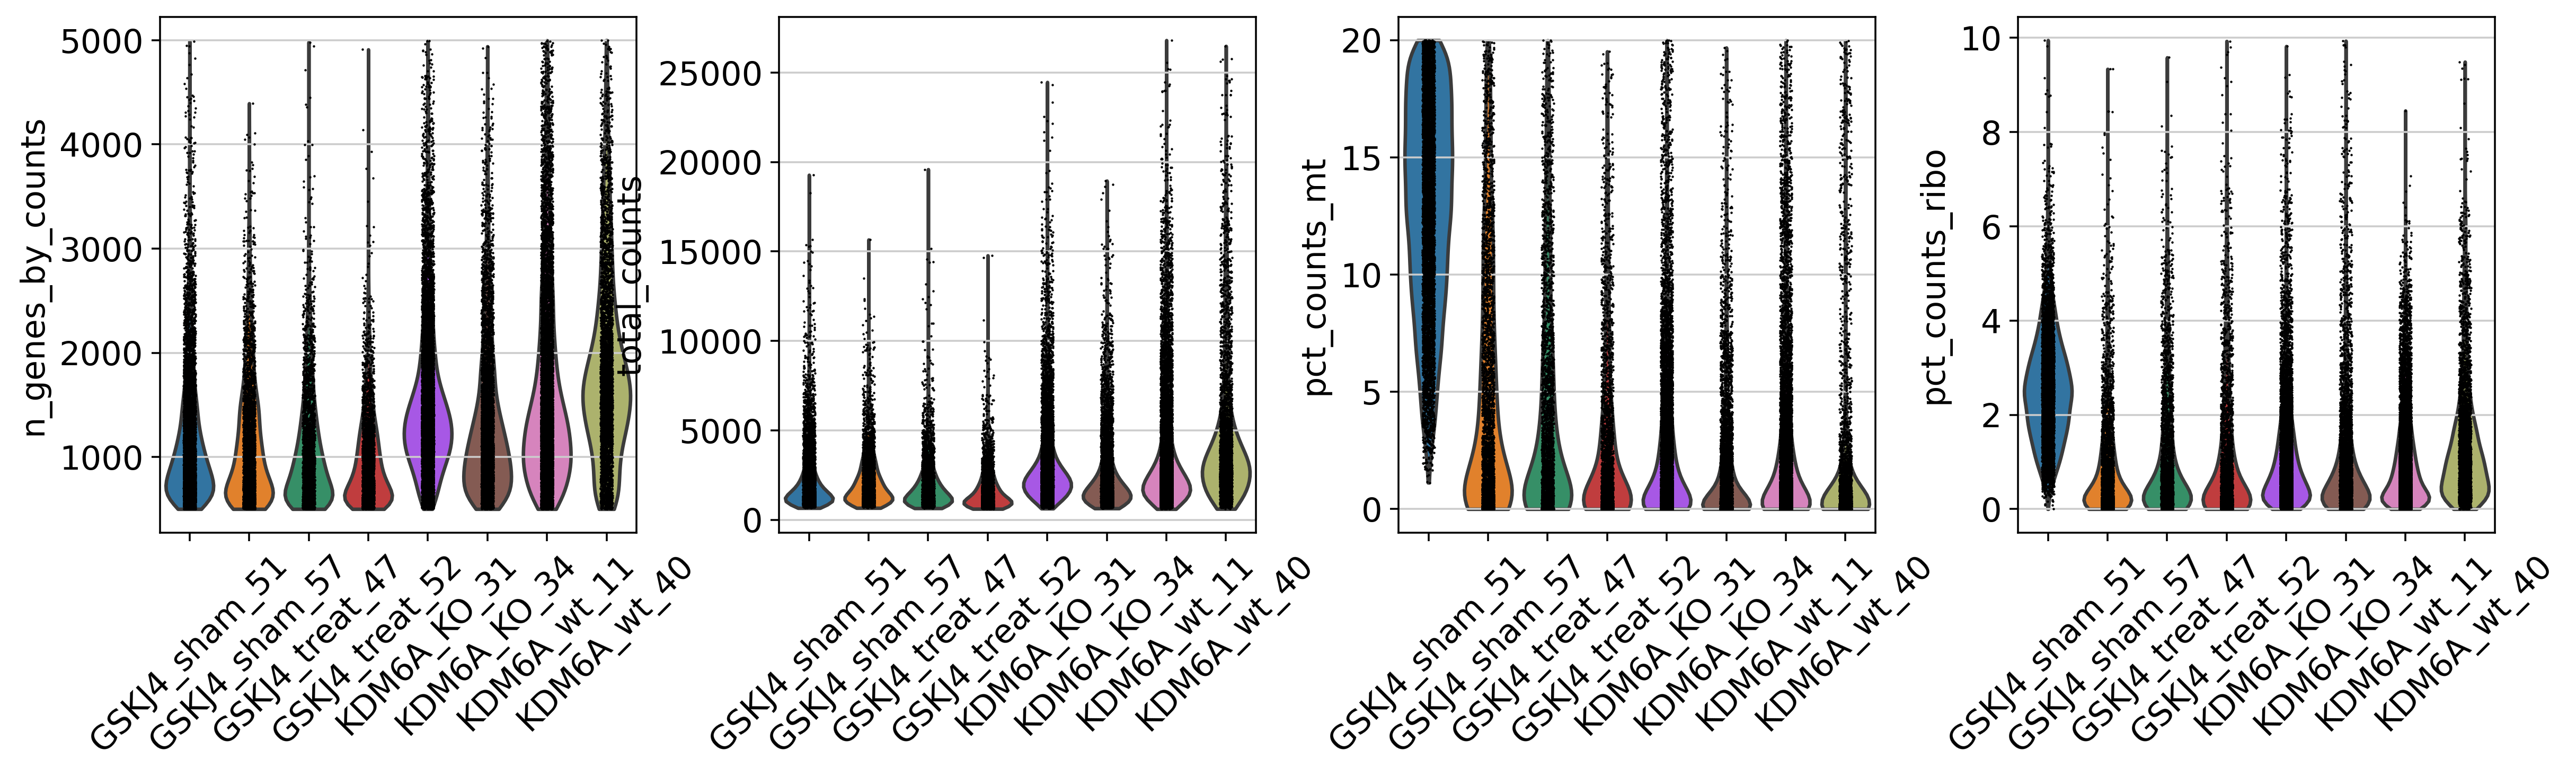

In [45]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter = 0.1, groupby = 'sample', rotation = 45)

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


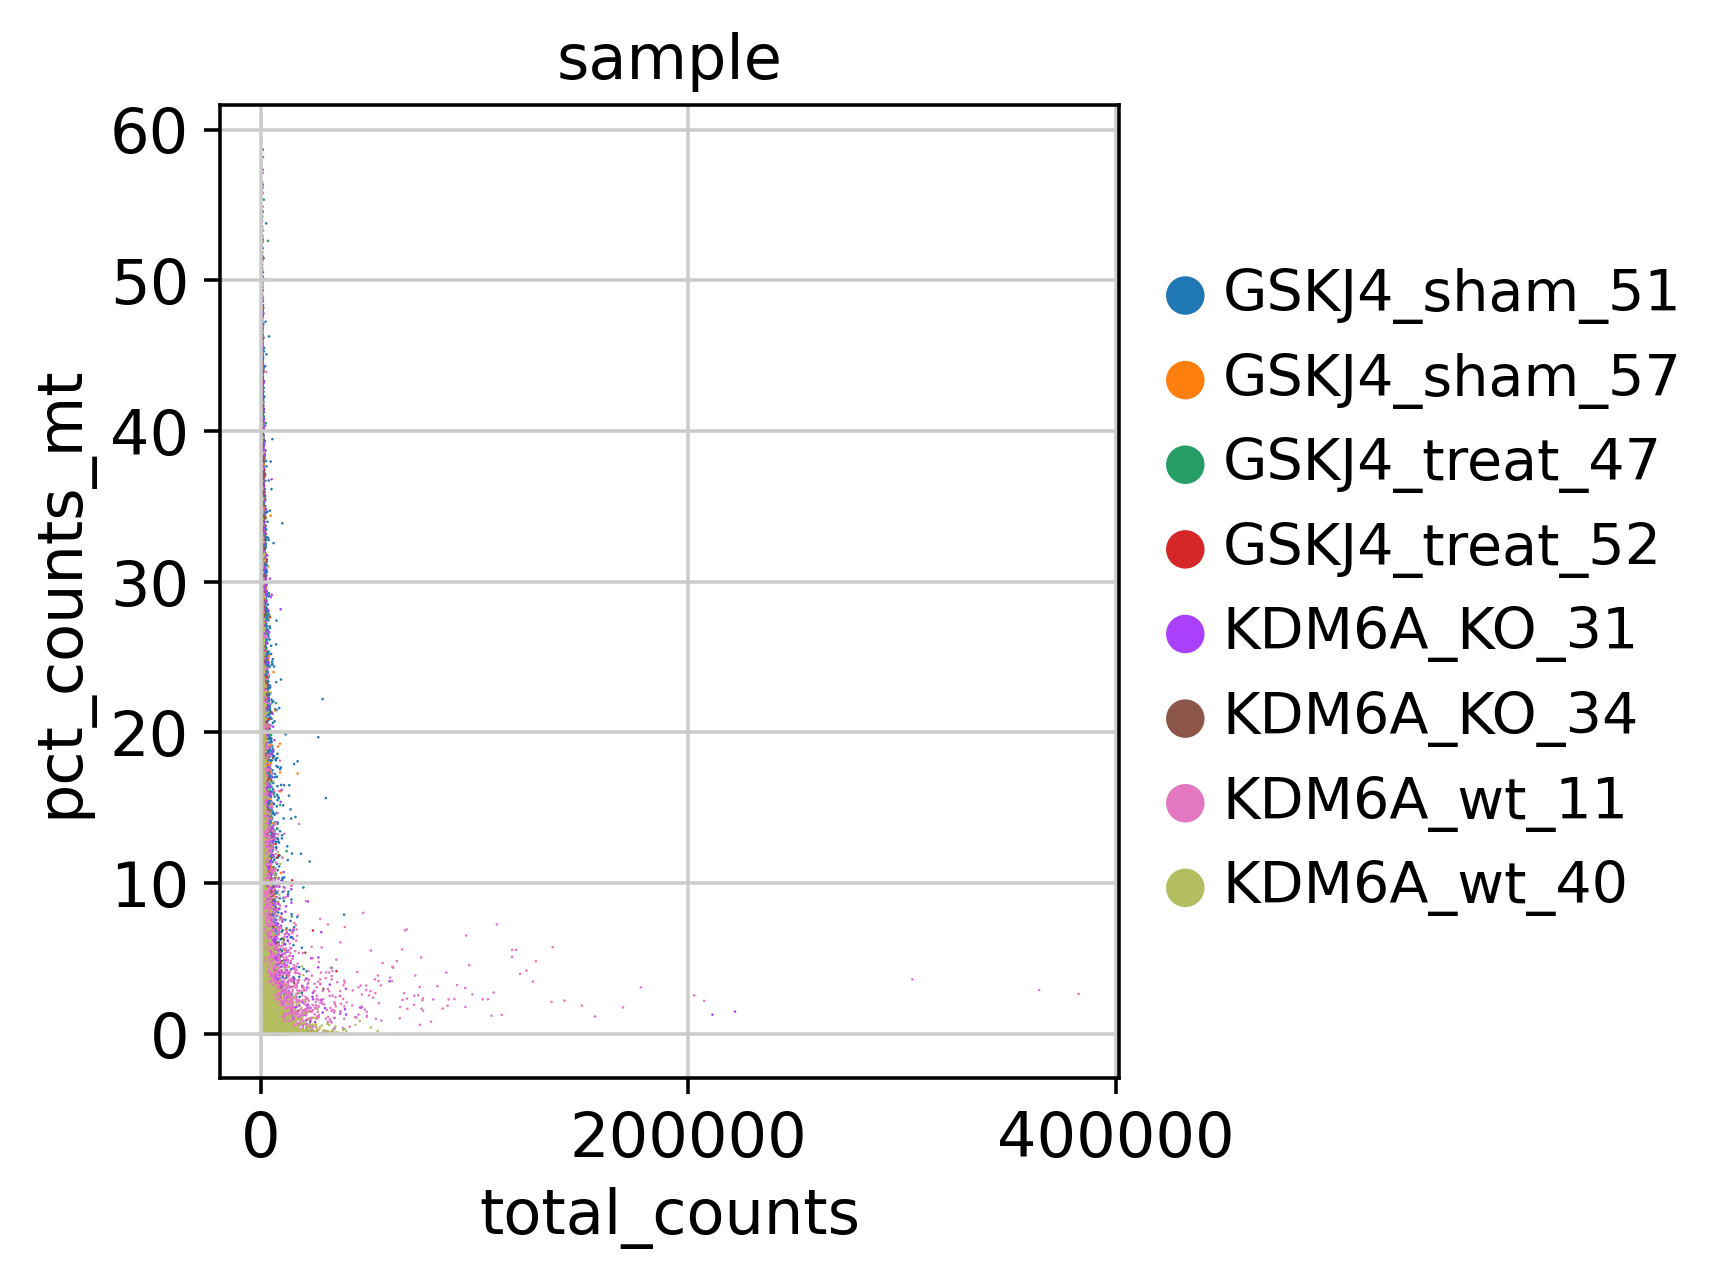

In [17]:
sc.pl.scatter(sample_object, x = 'total_counts', y = 'pct_counts_mt', color = "sample")

### Add sample sex covariate

In [18]:
annot = sc.queries.biomart_annotations(
        "mmusculus",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [19]:
annot.head()

ensembl_gene_id  start_position  end_position  \
external_gene_name                                                     
mt-Tf               ENSMUSG00000064336               1            68   
mt-Rnr1             ENSMUSG00000064337              70          1024   
mt-Tv               ENSMUSG00000064338            1025          1093   
mt-Rnr2             ENSMUSG00000064339            1094          2675   
mt-Tl1              ENSMUSG00000064340            2676          2750   

                   chromosome_name  
external_gene_name                  
mt-Tf                           MT  
mt-Rnr1                         MT  
mt-Tv                           MT  
mt-Rnr2                         MT  
mt-Tl1                          MT

In [20]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['Gm29089', 'Zfy1', 'Uba1y', 'Gm28588', 'Gm28587', 'Kdm5d', 'Eif2s3y',
       'Gm29650', 'Uty', 'Ddx3y',
       ...
       'Gm28672', 'Gm28670', 'Gm28673', 'Gm28674', 'Gm21996', 'Gm28930',
       'Gm29504', 'Gm20837', 'Gm28300', 'Gm28301'],
      dtype='object', length=719)

In [21]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1) * 100

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


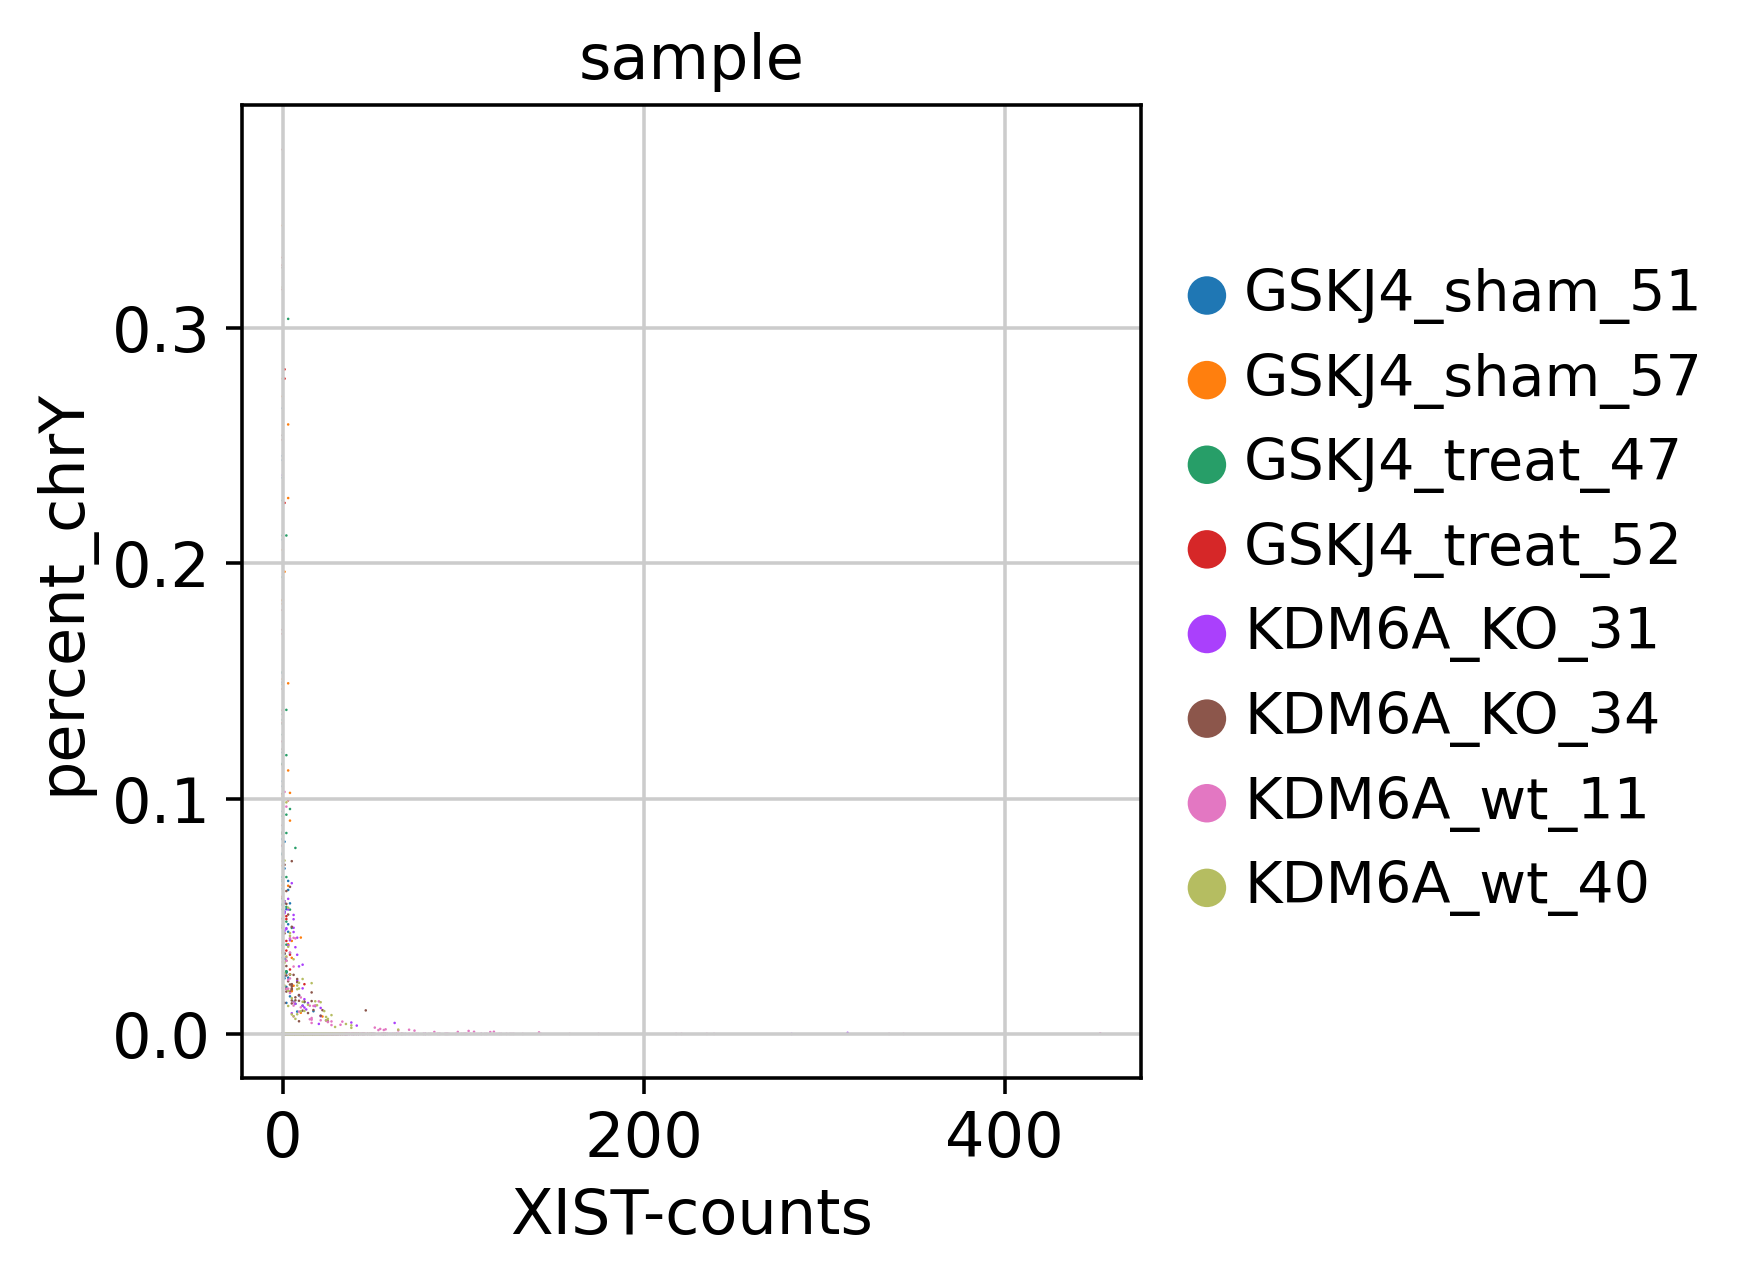

In [22]:
xist_counts = sample_object.X[:, sample_object.var_names.str.match('Xist')].toarray()
xist_counts_series = pd.Series(xist_counts.squeeze(), index = sample_object.obs_names, name = "XIST-counts")
sample_object.obs["XIST-counts"] = xist_counts_series

sc.pl.scatter(sample_object, x = 'XIST-counts', y = 'percent_chrY', color = "sample")

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldc

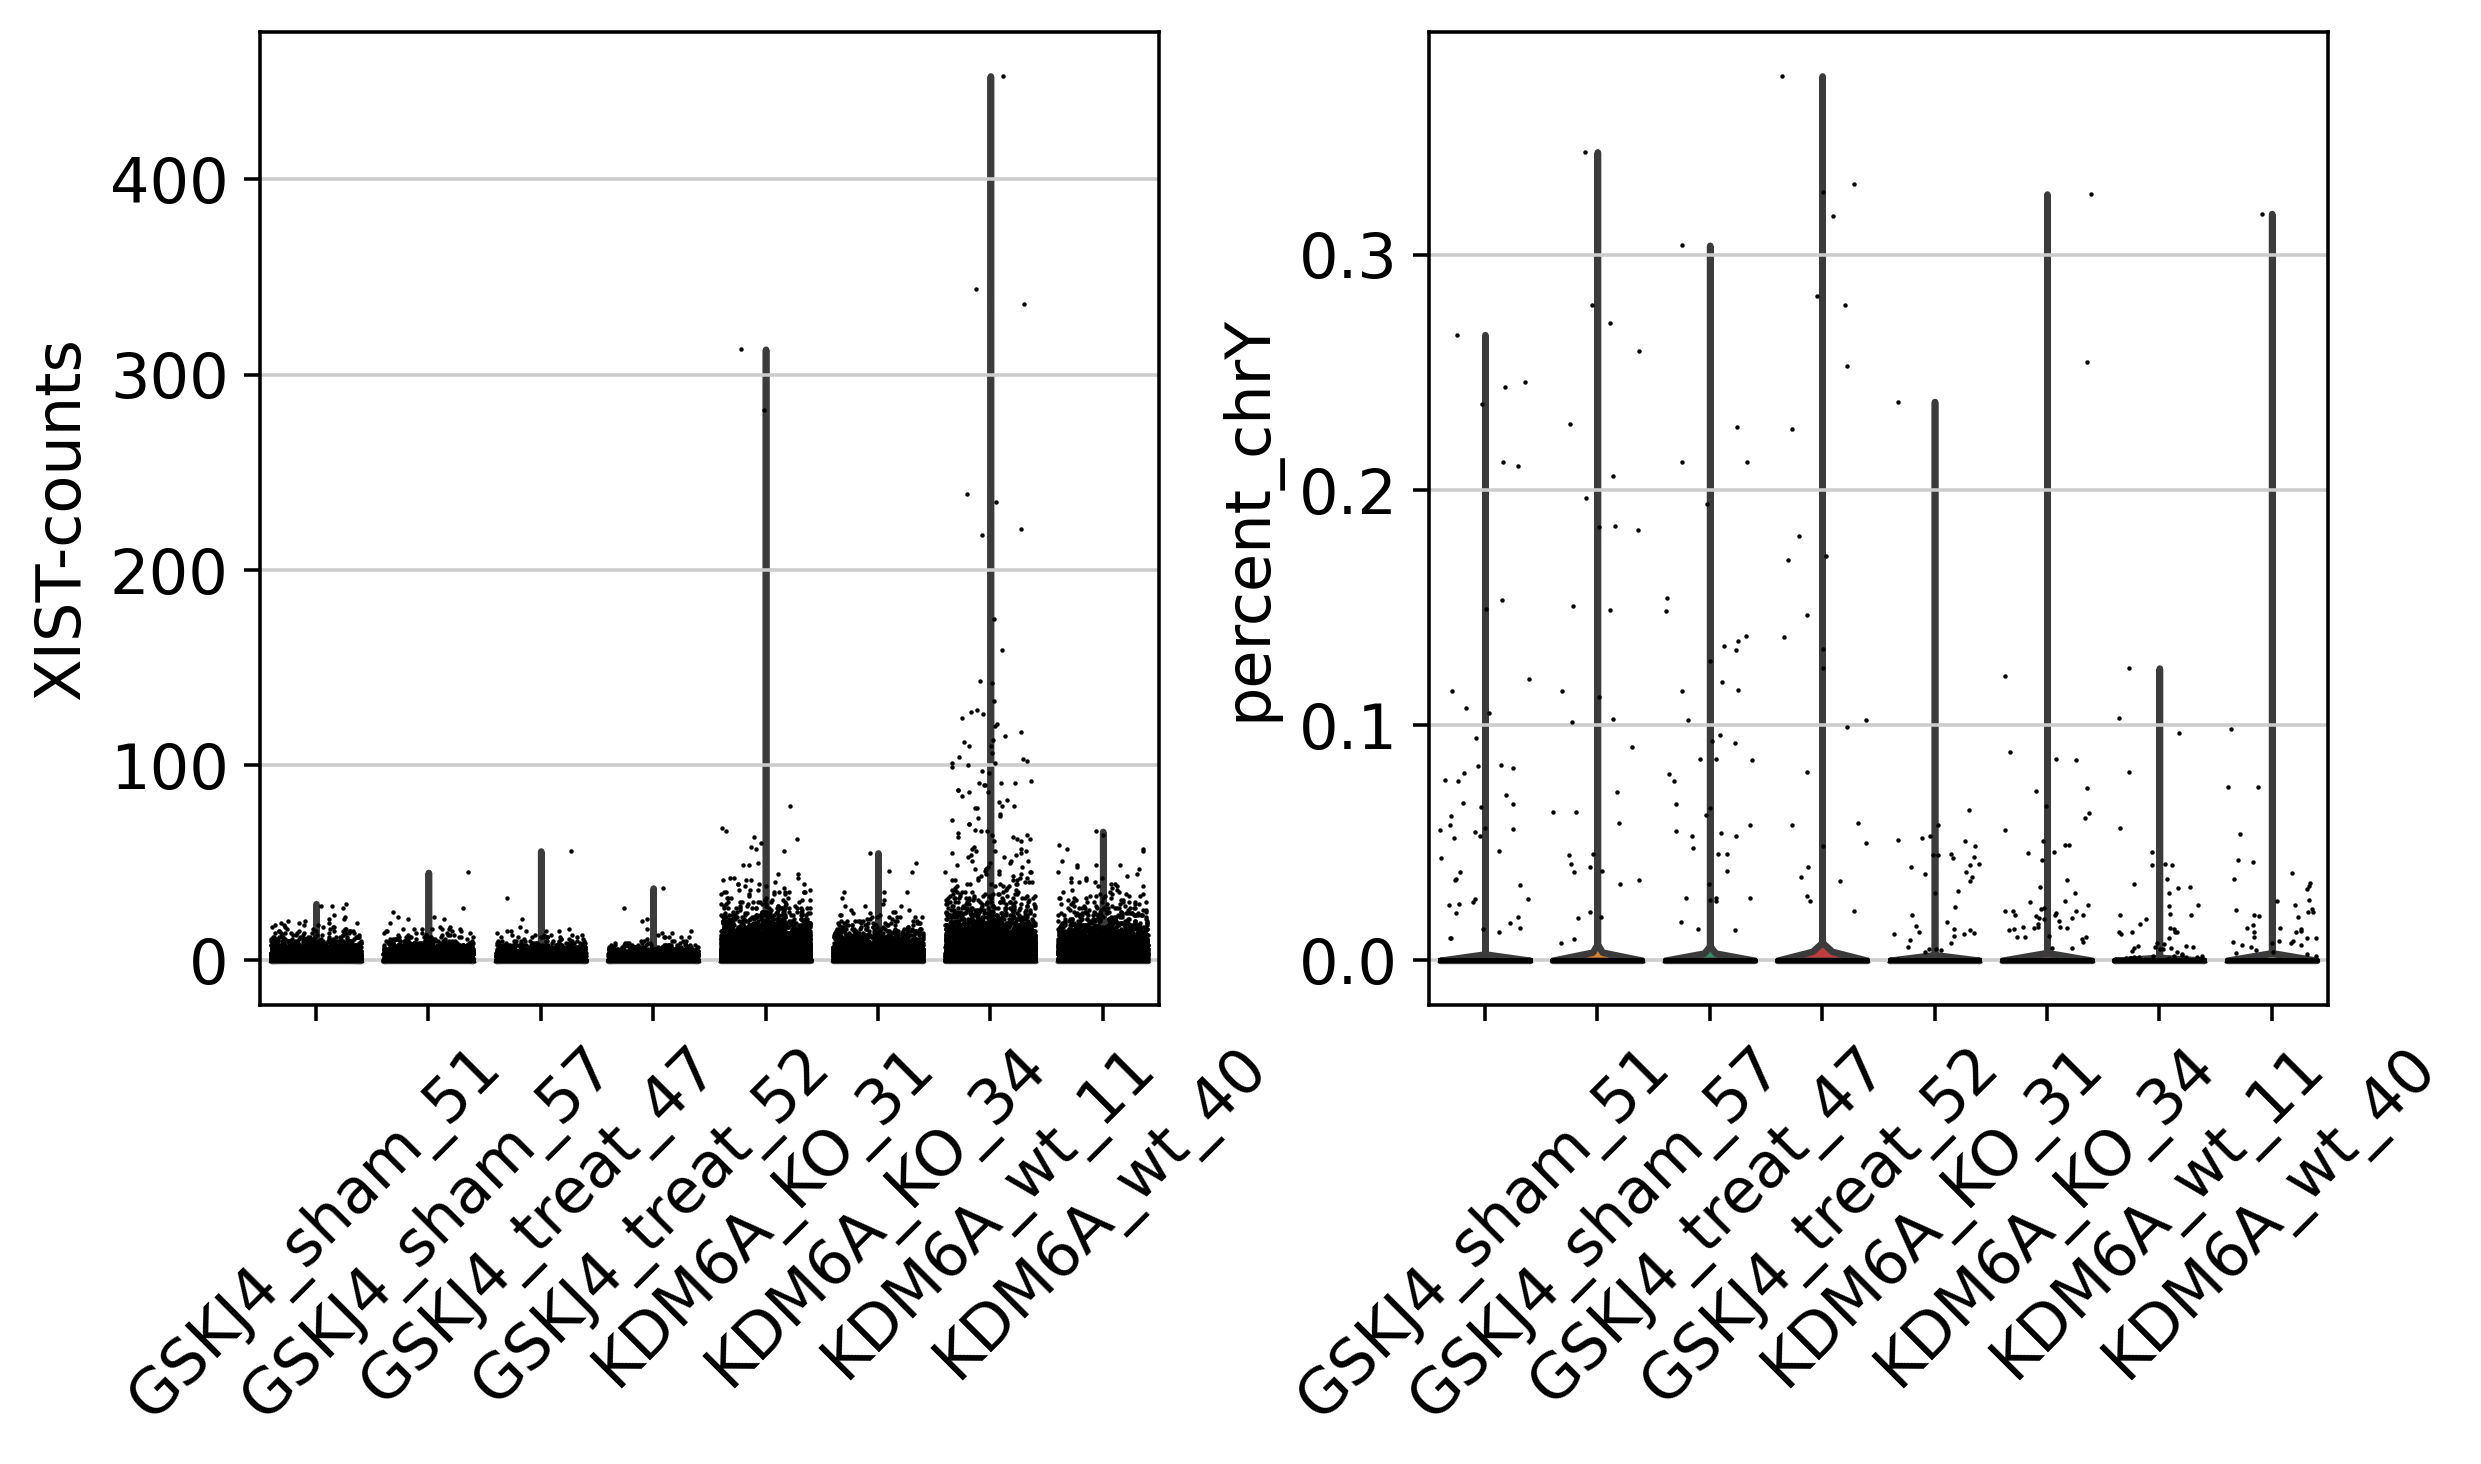

In [23]:
sc.pl.violin(sample_object, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby = 'sample', rotation = 45)

### Calculate cell cycle scores

In [24]:
!if [ ! -f ../data/regev_lab_cell_cycle_genes.txt ]; then curl -o ../data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [25]:
cell_cycle_genes = [x.strip() for x in open('../data/regev_lab_cell_cycle_genes.txt')]
cell_cycle_genes = [gene.capitalize() for gene in cell_cycle_genes]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

97
94


- Create basic `anndata` for score calculation

In [26]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Fhl2', 'Plcl1', 'Erbb4', 'Igfbp5', 'Tnnt2', 'Camk1d', 'Gsn', 'Xirp2', 'Ttn', 'Gm10800', 'Cst3', 'Mecom', 'Pdlim5', 'Gm12381', 'Ccl21a', 'Ptprd', 'Nppa', 'Pcdh7', 'Spp1', 'Atp2a2', 'Eln', 'Kcnd2', 'Igkc', 'Cacna1c', 'Mgp', 'Gab2', 'Hbb-bt', 'Hbb-bs', 'Csmd1', 'Dlc1', 'Sorbs2', 'Tpm1', 'Ngp', 'Lars2', 'Grm1', 'Nkain2', 'Ctnna3', 'Dcn', 'Hba-a1', 'Hba-a2', 'Myocd', 'Rgs6', 'Meg3', 'Rian', 'Ighg2c', 'Ighg2b', 'Ighm', 'Ryr2', 'Pde4d', 'Arl15', 'Dnah12', 'Myh6', 'Pcdh9', 'Dach1', 'Gpc6', 'Rbfox1', 'Zbtb20', 'Cmss1', 'Gm26917', 'Gm42418', 'AY036118', 'Slc8a1', 'Fhod3', 'Cd74', 'Malat1', 'Scgb1a1', 'Prkg1', 'Sorbs1', 'Fgf13', 'Dmd', 'Xist', 'Pcdh11x', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4', 'mt-Cytb']
    finished (0:00:00)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    473 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    513 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldc

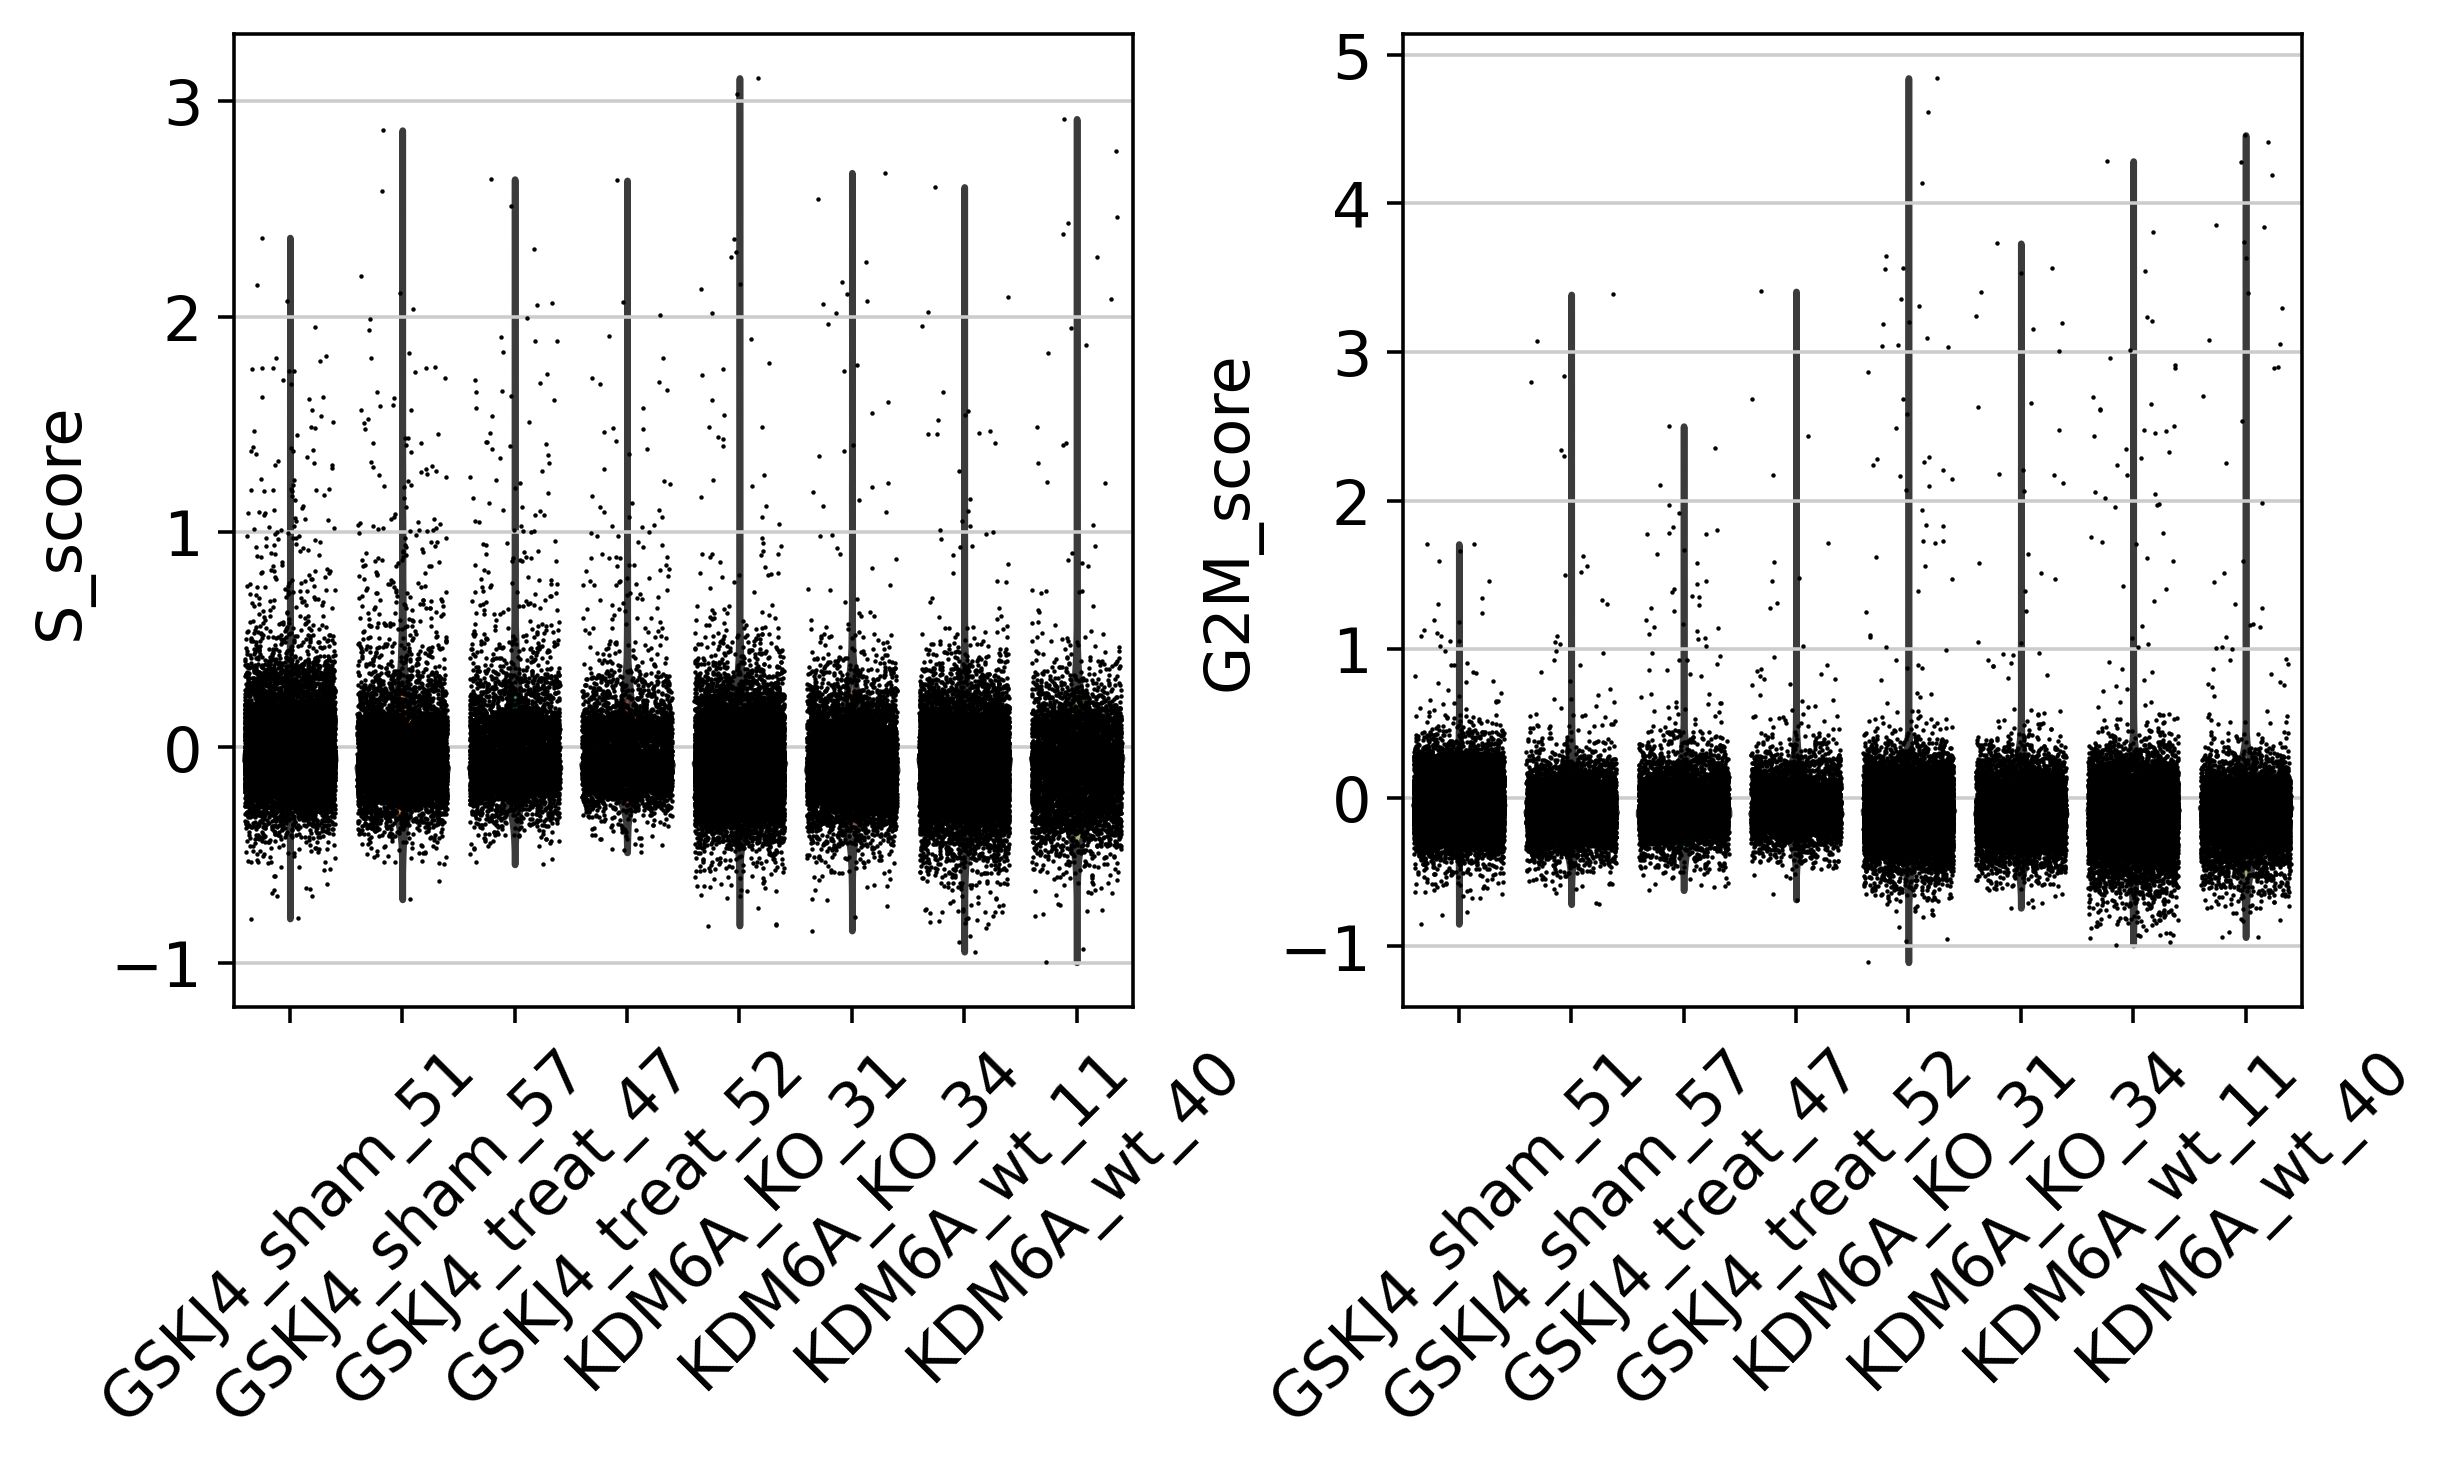

In [27]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'sample', rotation = 45)

In [28]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

AnnData object with n_obs × n_vars = 90537 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldc

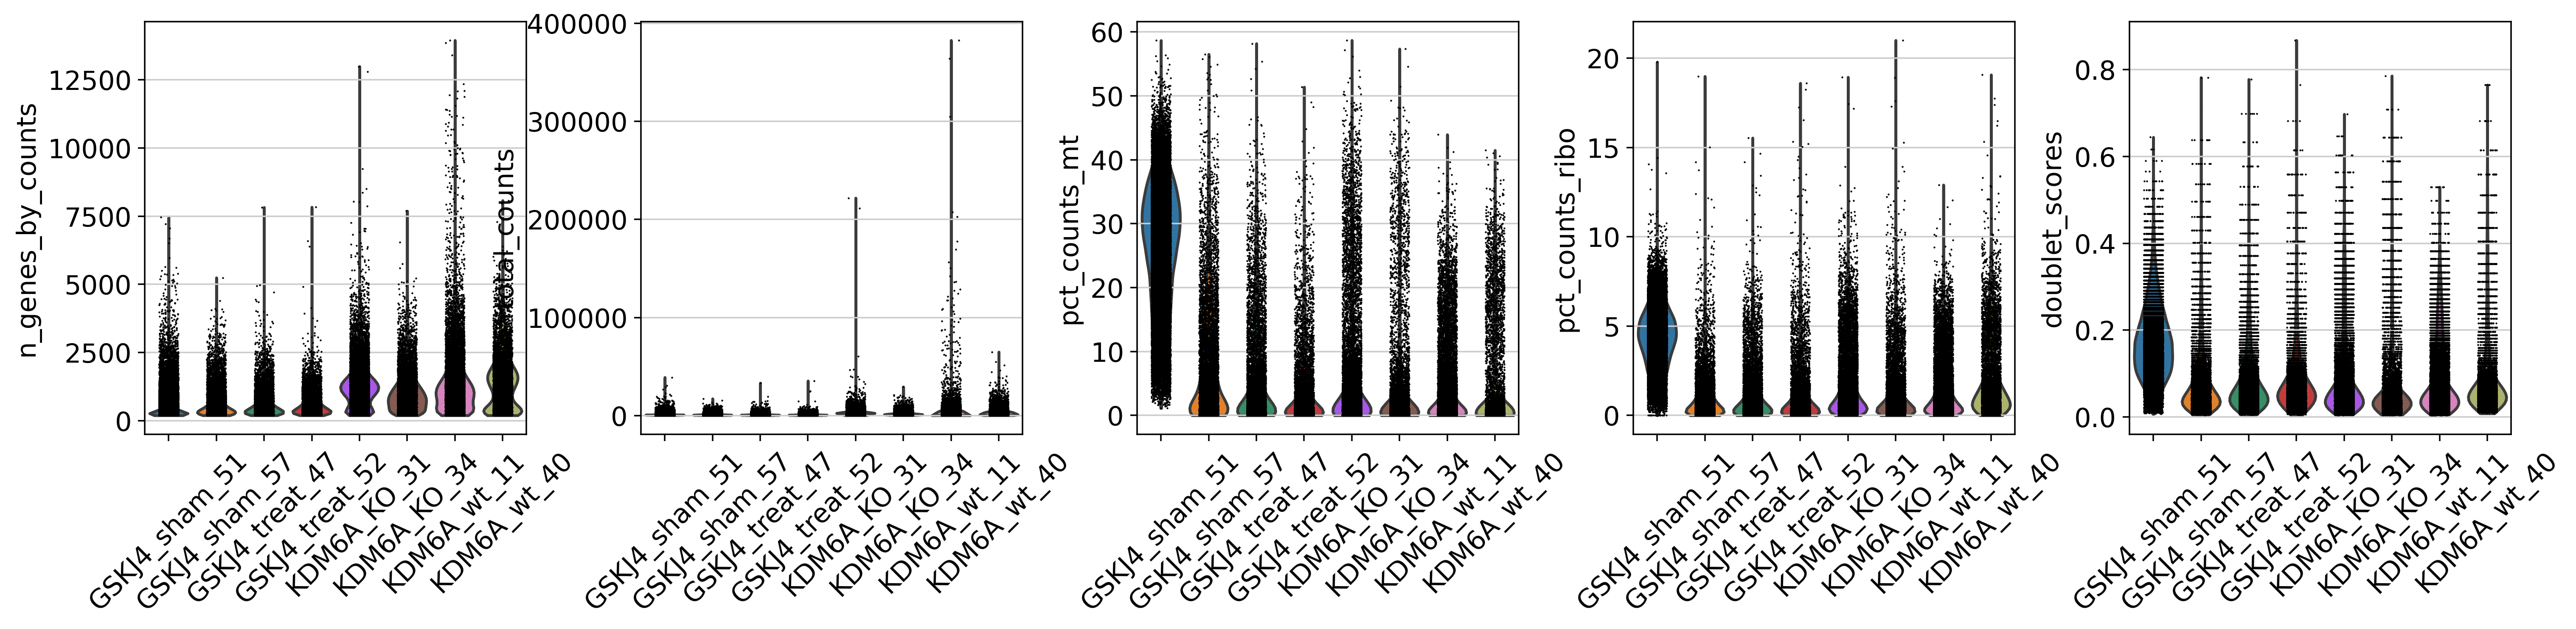

In [29]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'doublet_scores'],
             jitter = 0.2, groupby = 'sample', rotation = 45)

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldc

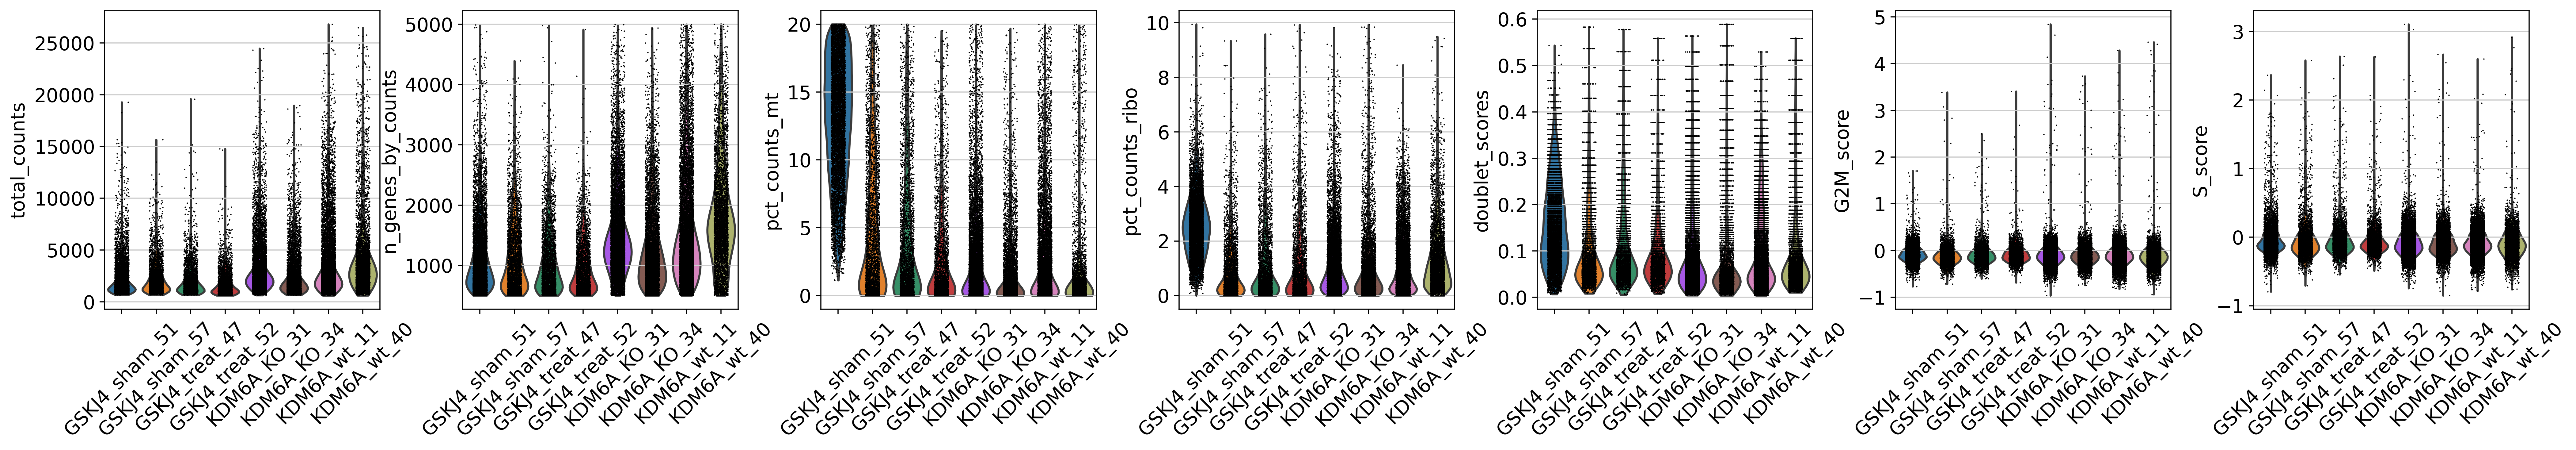

In [46]:
sc.pl.violin(sample_object, [ 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo', 'doublet_scores', 'G2M_score', 'S_score'],
             jitter = 0.2, groupby = 'sample', rotation = 45)

### Remove cells based on QC metrics

In [31]:
sample_object = sample_object[sample_object.obs['n_genes'] > 500]
sample_object = sample_object[sample_object.obs['n_genes'] < 5000]

sample_object = sample_object[sample_object.obs['total_counts'] > 500]
sample_object = sample_object[sample_object.obs['total_counts'] < 30000]

sample_object = sample_object[sample_object.obs['pct_counts_mt'] < 20]
sample_object = sample_object[sample_object.obs['pct_counts_ribo'] < 10]

sample_object = sample_object[sample_object.obs['doublet_scores'] < 0.6]

sample_object

View of AnnData object with n_obs × n_vars = 46136 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'

/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/ruth/mambaforge/envs/scanpy/lib/python3.9/site-packages/seaborn/_oldc

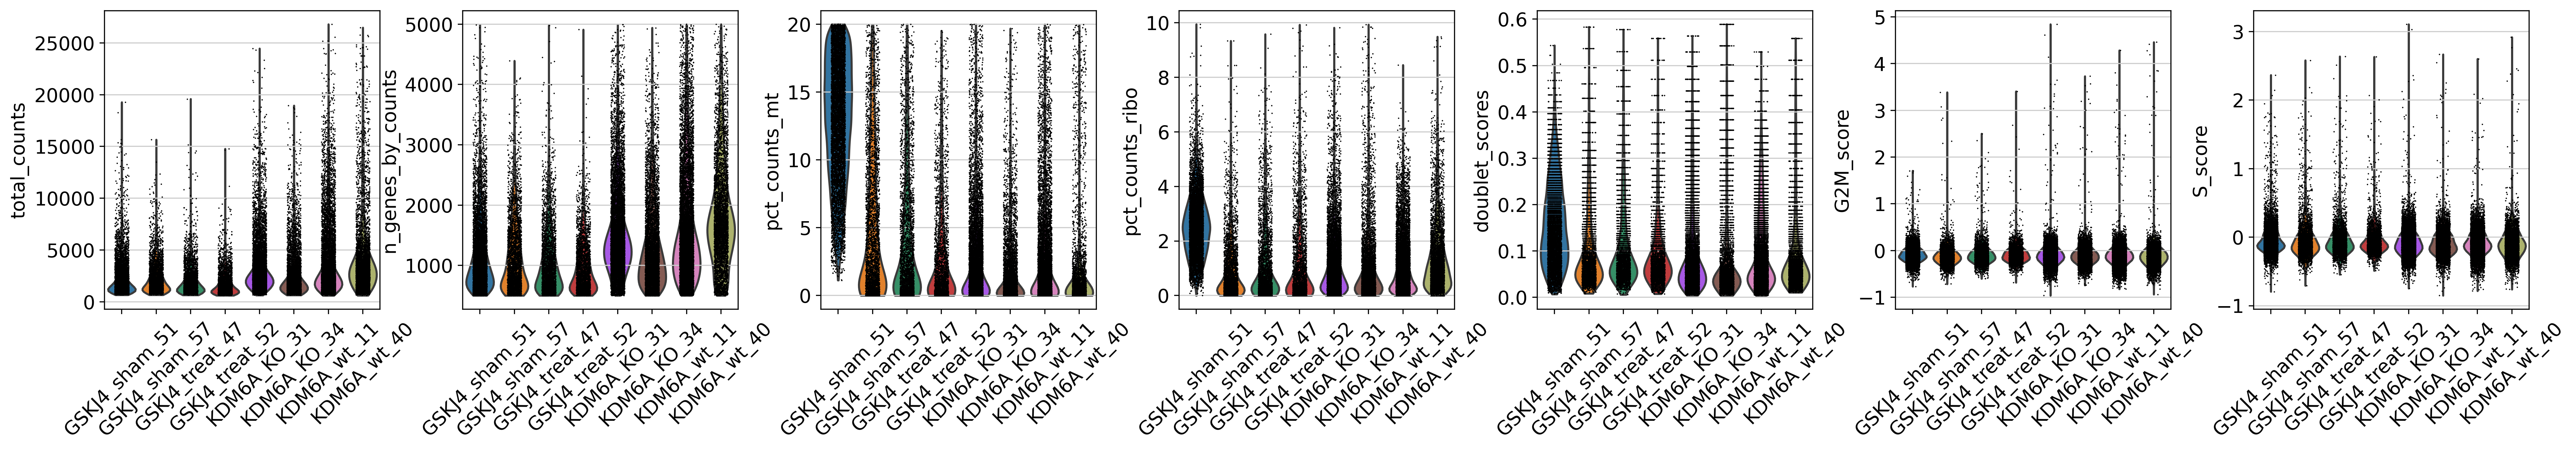

In [48]:
sc.pl.violin(sample_object, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo', 'doublet_scores', 'G2M_score', 'S_score'],
             jitter = 0.2, groupby = 'sample', rotation = 45)

### Prepare counts for individual slots

In [33]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 46136 × 32285
    obs: 'sample', 'genotype', 'group', 'file', 'batch', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'genome', 'modality', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [34]:
del(sample_object.obs['predicted_doublets'])

### Export object